<a href="https://colab.research.google.com/github/brianshin12/zeta/blob/master/Chapter7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys, os
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks/dataset')
import mnist
from mnist import load_mnist 
import numpy as np
import matplotlib.pylab as plt
from collections import OrderedDict
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks/common')
from functions import softmax, cross_entropy_error
from gradient import numerical_gradient
def sigmoid(x):
  return 1 / (1+np.exp(-x))
def Relu(x):
  return np.maximum(0, x)
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks/')
from common.util import im2col
from common.trainer import Trainer
import pickle
from common.layers import *

In [0]:
class Convolution:
  def __init__(self, W, b, stride=1, pad=0): #인수 초기화
    self.W = W
    self.b = b
    self.stride = stride
    self.pad = pad
  
  def forward(self, x):
    FN, C, FH, FW = self.W.shape #필터
    N, C, H, W = x.shape #입력데이터
    out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
    out_w = int(1 + (W + 2*self.pad - FW) / self.stride)

    col = im2col(x, FH, FW, self.stride, self.pad) #입력 데이터를 im2col으로 전개
    col_W = self.W.reshape(FN, -1).T #필터를 reshape 사용하여 2차원 배열로 전개
    out = np.dot(col, col_W) + self.b #전개한 두 행렬의 곱 + 편차

    out = out.reshape(N, out_h, out_w, -1).transpose(0,3,1,2) #transpose를 사용하여 출력데이터의 축 순서 변경

    return out

In [0]:
class Pooling:
  def __init__(self, pool_h, pool_w, stride=1, pad=0):
    self.pool_h = pool_h
    self.pool_w = pool_w
    self.stride = stride
    self.pad = pad

  def forward(self, x):
    N, C, H, W = x.shape
    out_h = int(1 + (H - self.pool_h) / self.stride)
    out_w = int(1 + (W - self.pool.w) / self.stride)

    #전개
    col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
    col = col.reshape(-1, self.pool_h * self.pool_w)

    #최댓값
    out = np.max(col, axis=1) #첫번째 차원의 축마다 최댓값 계산

    #성형
    out = out.reshape(N, out_h, out_w, C).transpose(0,3,1,2)

    return out

## 7.5 CNN구현하기  
합성곱 계층과 풀링 계층을 조합하여 손글씨 숫자를 인식하는 CNN을 구현해보겠습니다.  
* Input $\rightarrow$ Conv(합성곱 계층) $\rightarrow$ ReLU $\rightarrow$ Pooling(풀링 계층) $\rightarrow$ Affine $\rightarrow$ ReLU $\rightarrow$ Affine $\rightarrow$ Softmax  


초기화(\_\_init__) 때 받는 인수  
* input_dim : 입력 데이터(채널 수, 높이, 너비)의 차원  
* conv_param : 합성곱 계층의 하이퍼파라미터 (딕셔너리 형태)  
    1. filter_num : 필터 수  
    2. filter_size : 필터 크기  
    3. stride : 스트라이드  
    4. pad : 패딩  
* higgen_size : 은닉층(완전연결)의 뉴런 수  
* output_size : 출력층(완전연결)의 뉴런 수  
* weight_init_std : 초기화 때의 가중치 표준편차  


In [0]:
class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        # 쓰기 쉽도록 딕셔너리 값을 꺼내어 변수 지정

        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        # 합성곱 계층의 출력 크기 계산

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        # 1번째 층의 합성곱 계층의 가중치 및 편향
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        # 2번째 층의 완전연결 계층의 가중치 및 편향
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        # 3번째 층의 완전연결 계층의 가중치 및 편향

        # CNN을 구성하는 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

# 추론을 수행하는 predict / 손실 함수의 값을 구하는 loss
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

train loss:2.3000268423331116
=== epoch:1, train acc:0.241, test acc:0.189 ===
train loss:2.297303897749794
train loss:2.2949004471887533
train loss:2.2873106980097844
train loss:2.2810838883365
train loss:2.273402408168741
train loss:2.2499615047407024
train loss:2.2363226334352917
train loss:2.226550646671099
train loss:2.2059696556298953
train loss:2.1538767675116417
train loss:2.123663548106514
train loss:2.055195213705233
train loss:2.053979247161511
train loss:2.000216440119104
train loss:1.925907981978532
train loss:1.8385495091741957
train loss:1.7952901639115262
train loss:1.6764863500349265
train loss:1.65931664291933
train loss:1.4294292658888548
train loss:1.492046873615424
train loss:1.3388718499768066
train loss:1.409670974347756
train loss:1.1932042011147426
train loss:1.1397121867179043
train loss:1.0500461026071963
train loss:1.003745363151504
train loss:0.8962046754275624
train loss:0.9373284859366688
train loss:0.8438700295670999
train loss:0.8141210981470397
train l

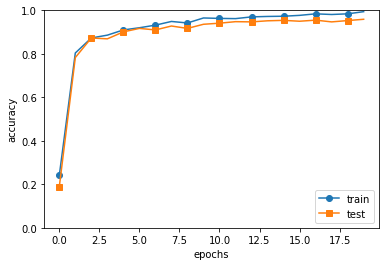

In [0]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### 7.5.1 CNN 성능 향상 방법  
CNN의 성능을 향상시키는 가장 직접적인 방법은 망의 크기를 늘리는 것입니다.  
여기서 망의 크기를 늘린다는 것은 망의 layer수(깊이)만을 늘리는 것뿐만 아니라, 각 layer의 넓이를 늘리는 것을 늘리는 것을 의미합니다.  
* 깊은 망의 부작용  
망이 깊어지면서 성능이 좋아지지만 2가지 문제가 발생합니다.  
    1. 자유파라미터의 수가 증가하게 됩니다.  
    학습에 사용할 데이터 양이 적은경우 오버피팅에 빠질 가능성이 높아집니다.  
    2. 연산량이 늘어납니다.  
    3. 기울기 손실이 발생합니다.  
    Sigmoid 대신 ReLU를 활성화함수로 이용하는 이유도 기울기 손실 문제를 해결하기 위해서 입니다. (Sigmoid함수 양 끝의 기울기$\rightarrow$0)

## 7.6 CNN 시각화하기  
### 7.6.1 1번째 층의 가중치 시각화하기
학습 전 필터는 무작위로 초기화되고 있어 흑백의 정도에 규칙성이 없습니다.  
반면 학습을 마친 필터는 에지와 블롭을 가진 규칙을 띄는 필터로 바뀌었습니다.  

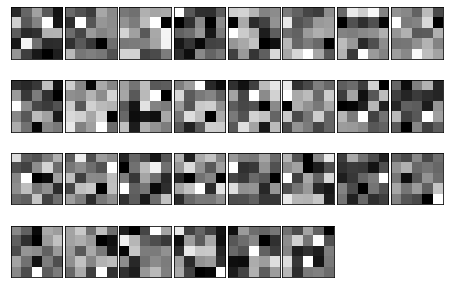

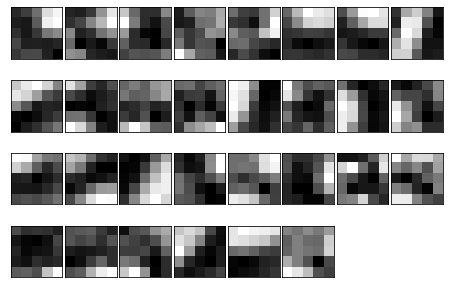

In [0]:
def filter_show(filters, nx=8, margin=3, scale=10):
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])

### 7.6.2 층 깊이에 따른 추출 정보 변화
1번째 층의 합성곱 계층에서 에지나 블롭 등의 저수준 정보를 추출할 수 있음을 확인했습니다.  
겹겹이 쌓인 CNN의 각 계층이 깊어질수록 추출되는 정보는 더 추상화됩니다.  

Ex)일반 사물 인식을 수행한 8층의 CNN네트워크  
1번째 층에서은 에지나 블롭을, 3번째 층에서 텍스처, 5번째 층에서 사물의 일부,  
마지막 완전연결 계층에서는 사물의 클래스(개, 자동차 등)에 뉴런이 반응합니다.  

층이 깊어지면서 신경망학습을 통해 사물의 '의미'를 이해할 수 있습니다.

## 7.7 대표적인 CNN  
![](https://tensorflowkorea.files.wordpress.com/2016/09/ilsvr2016-2.png)
### 7.7.1 LeNet
* 20년 전에 제안된 '첫 CNN'  
* 합성곱 계층과 풀링계층을 반복하고 완전연결 계층을 거치면서 결과 출력    
* 현재의 CNN과 차이점
  1. 활성화함수 : 시그모이드 / 현재는 주로 ReLU  
  2. 풀링계층 : 단순히 '원소를 줄이기'만 하는 서브샘플링 계층 / 현재는 주로 최대 풀링

<img width="514" alt="LeNet" src="https://user-images.githubusercontent.com/53211502/68599454-eee08400-04e3-11ea-9204-ad05c33336ab.PNG">

### 7.7.2  AlexNet  
<img width="536" alt="AlexNet" src="https://user-images.githubusercontent.com/53211502/68599686-5991bf80-04e4-11ea-9e36-19cdd7ac2968.PNG">

* 2012년에 발표
* LeNet의 특이사항.  
    1. 활성화 함수로 주로 ReLU를 이용
    2. LRN이라는 국소적 정규화를 실시하는 계층을 이용 
    3. 드롭아웃 사용(128배치 사이즈)
    4. SGD 모멘텀 사용
    5. CONV1 층을 보시면 두 개로 나눠져 있는데  
    3GB 메모리의 GPU 2개를 사용하여 연결한 네트워크 입니다.

<img width="81" alt="AlexNet structure" src="https://user-images.githubusercontent.com/53211502/68599943-e3da2380-04e4-11ea-946d-238edf8c63eb.PNG">  

Input : 227x227x3 images  
첫 번째 층(CONV1) : 96x11x11 (stride=4) 필터 이용  
$\rightarrow$ Output volume : ((227-11)/4+1=55) 55x55x96(필터 수) / parmameters : (11x11x3(input의 깊이))x96 = 35k  
두 번째 층(POOL1) : 3x3 (stride=2) 필터 사용  
$\rightarrow$ Output volume : ((55-3)/2+1=27) 27x27x96(pooling은 깊이 보존) / parmameters : 0 (pooling은 최댓값 혹은 평균값을 계산) 을 할 수 있습니다.

 



### 7.7.3 VGG  
<img width="140" alt="VGG" src="https://user-images.githubusercontent.com/53211502/68602134-243ba080-04e9-11ea-9caa-e3e220ccd53f.PNG">

* 옥스포드에서 개발
* AlexNet과 유사 (LRN 사용 X)
* 한 층 더 깊어진 네트워크(19layers) & 더 작아진 필터 이용(CONV 3x3)

![](https://i.stack.imgur.com/5tp2P.png)

3x3 3개의 필터 = 7x7 1개의 필터
$\rightarrow$ 더 적은 parameters (3x3x3<7x7)  

### 7.7.4 ResNet  
* 깊은 망의 문제점  
ResNet팀에서 20-layer, 56-layer에 대하여 비교 테스트를 진행하였습니다.  
그 결과로는 56-layer의 오차가 더 높았습니다.  
그 원인으로는 기울기 손실이 발생하였기 때문입니다.  

<img width="398" alt="ResNet2" src="https://user-images.githubusercontent.com/53211502/68604068-fb1d0f00-04ec-11ea-8b37-5f1bb169869e.PNG">

* skip connection  
기존의 신경망의 학습 목적이 입력(x)을 타겟값(y)으로 모델링하는 함수  
H(x)를 찾는 것이라고 한다면, H(x)−y를 최소화 하는 방향으로 학습을 진행합니다.   
이 때 x와 짝지어진 y는 사실 x를 대변하는 것으로, 특히 이미지 분류 문제에서는 네트워크의 입 출력을 의미상 같게끔 해야합니다.  
그래서 ResNet에서는 관점을 바꿔 네트워크가 H(x)−x를 얻는 것으로 목표를 수정하였습니다.  
입력과 출력의 잔차를 F(x)=H(x)−x라고 정의하고 네트워크는 이 F(x)를 찾는 것입니다.  
이렇게 잔차를 학습하는 것을 Residual learning, Residual mapping이라고 합니다.  
이렇게 네트워크의 입력과 출력이 더해진 것을 다음 레이러의 입력으로 사용하는 것을 스킵연결(skip connection) 이라고 한다.  
기존의 신경망은 H(x)가 어떻게든 정답과 같게 만드는 것이 목적이었다면, 이제 입력과 출력 사이의 잔차를 학습하는 것, 즉 최적의 경우  F(x)=0 이 되어야하므로 학습의 목표가 이미 정해져 있기 때문에 학습 속도가 빨라질 것이고, 네트워크가 잔차를 학습하고 나면, 입력값의 작은 변화에도 민감하게 반응 할 것이다라는 것이 ResNet의 가설입니다.